## Import

In [4]:
import numpy as np
import functions as fc
from timeit import default_timer as time
from fatiando.gravmag import polyprism
from fatiando import mesher, gridder
from fatiando.gravmag import prism
from fatiando.constants import G, SI2MGAL
from scipy.sparse import diags
from matplotlib import pyplot as plt
from scipy.interpolate import griddata
from scipy import interpolate, signal
import pandas as pd
from fatiando.vis import mpl
import cPickle as pickle
%matplotlib inline

## Observed Grid and Data

In [5]:
with open('carajas_gz.pickle') as r:
    carajas = pickle.load(r)

In [6]:
grid_x = carajas['x']
grid_y = carajas['y']
grid_z = carajas['z']
grid_dobs = carajas['gz']

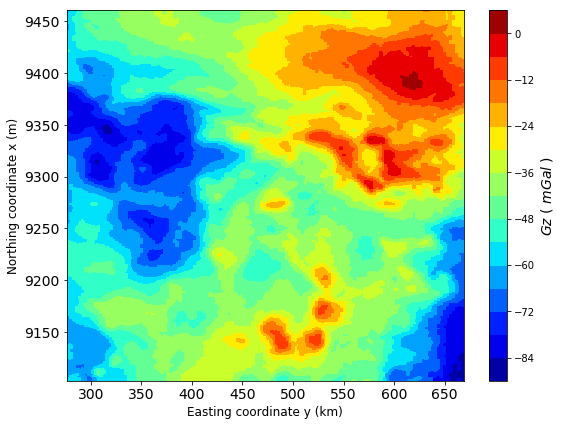

In [7]:
plt.figure(figsize=(8,6))
plt.plot()
plt.tricontourf(np.ravel(grid_y),np.ravel(grid_x),np.ravel(grid_dobs),15,cmap='jet')
#cb = plt.colorbar(shrink=0.825)
cb = plt.colorbar()
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(grid_y),np.max(grid_y))
plt.ylim(np.min(grid_x),np.max(grid_x))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('figures/carajas_real_data.png', dpi=300)

## Equivalent layer Depth

In [8]:
# Equivalent Layer depth
shape_m = (500, 500)
zj = np.ones_like(grid_z)*300

## Fast Eq. Layer Combined with Circulant-Toeplitz (BCCB)

In [9]:
# Predicted data
s = time()
itmax = 50
rho_toep, gzp_toep = fc.fast_eq_bccb(np.ravel(grid_x),np.ravel(grid_y),np.ravel(grid_z),
                                  np.ravel(zj),shape_m,np.ravel(grid_dobs),itmax)
e = time()
tcpu = e - s
print tcpu

7.1485337


## Property estimative plot

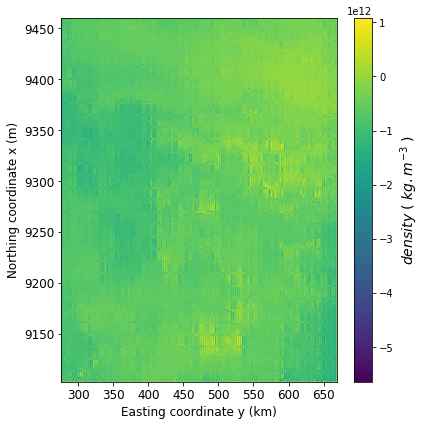

In [12]:
plt.figure(figsize=(6,6))

plt.plot()
plt.pcolormesh(grid_y.reshape(shape_m), grid_x.reshape(shape_m),rho_toep.reshape(shape_m))
#plt.tricontourf(yi,xi,rho_toep,30,cmap='jet')
cb = plt.colorbar()
#plt.axis('scaled')
cb.set_label('$density$ ( $kg.m^{-3}$ )', rotation=90, fontsize=14)
plt.xlim(np.min(grid_y),np.max(grid_y))
plt.ylim(np.min(grid_x),np.max(grid_x))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('figures/rho_carajas_500x500.png', dpi=300)
plt.show()

## Data, Predicted data and Residuals plot

## Fast Equivalent layer BCCB plot

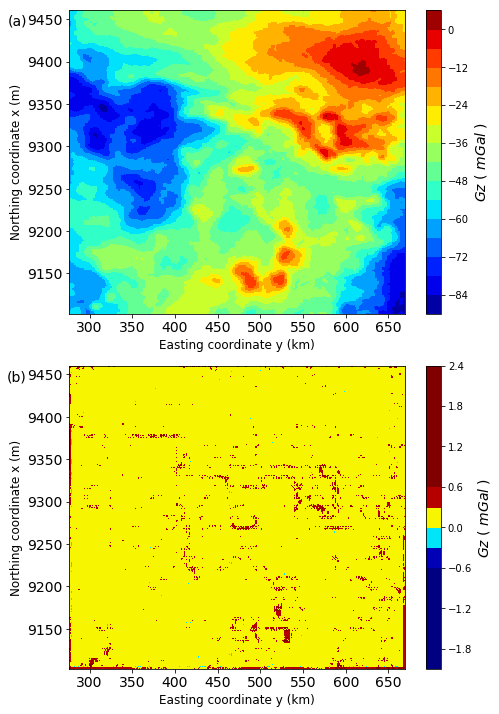

In [19]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(7,10))

#plt.subplot(311)
#plt.title('A)', y=0.91, x=0.1, fontsize=18)
#plt.tricontourf(np.ravel(grid_y),np.ravel(grid_x),np.ravel(grid_dobs),15,cmap='jet')
#cb = plt.colorbar()
##plt.axis('scaled')
#cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
#plt.xlim(np.min(yi_c),np.max(yi_c))
#plt.ylim(np.min(xi_c),np.max(xi_c))
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=12)
#plt.ylabel('Northing coordinate x (m)', fontsize=12)
#mpl.m2km()

plt.subplot(211)
plt.title('(a)', y=0.93, x=-0.155, fontsize=14)
plt.tricontourf(np.ravel(grid_y),np.ravel(grid_x),gzp_toep,15,cmap='jet')
cb = plt.colorbar()
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(grid_y),np.max(grid_y))
plt.ylim(np.min(grid_x),np.max(grid_x))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()

delta_gz = gzp_toep-np.ravel(grid_dobs)
plt.subplot(212)
plt.title('(b)', y=0.93, x=-0.155, fontsize=14)
plt.tricontourf(np.ravel(grid_y),np.ravel(grid_x),delta_gz,15, vmin=-0.5, vmax=0.5, cmap='jet')
cb = plt.colorbar()
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(grid_y),np.max(grid_y))
plt.ylim(np.min(grid_x),np.max(grid_x))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
plt.tight_layout(True)
plt.savefig('../manuscript/Fig/Figure13_r1.png', dpi=300)

In [20]:
mean = np.mean(delta_gz)
print mean
std = np.std(delta_gz)
print std

0.00029344162027713827
0.11582389596376169


## Transformation - Upward Continuation

In [21]:
# BTTb Eq. Layer Transformation
N = shape_m[0]*shape_m[1]
z_up = np.zeros_like(grid_x)-5000
s = time()
BTTB_up = fc.bttb(np.ravel(grid_x),np.ravel(grid_y),np.ravel(z_up),np.ravel(zj))
cev_up = fc.bccb(shape_m,N,BTTB_up)
gzp_bccb_up = fc.fast_forward_bccb(shape_m,N,rho_toep,cev_up)
e = time()
tcpu = e - s
print tcpu

0.2141611


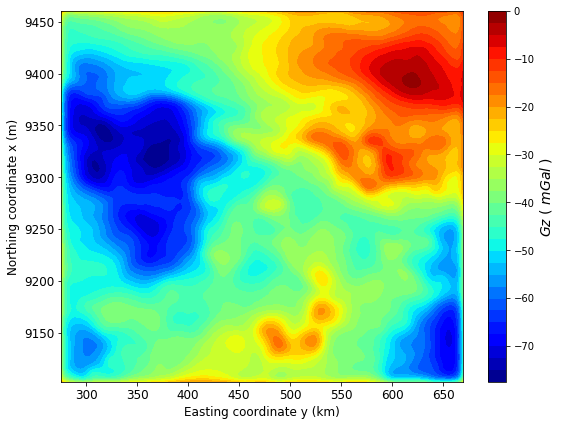

In [23]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(8,6))

plt.tricontourf(np.ravel(grid_y),np.ravel(grid_x),gzp_bccb_up,30,cmap='jet')
cb = plt.colorbar()
#plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(grid_y),np.max(grid_y))
plt.ylim(np.min(grid_x),np.max(grid_x))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('figures/up2000_carajas_500x500.png', dpi=300)
plt.show()

## Transformation - Downward Continuation

In [52]:
# BTTb Eq. Layer Transformation
N = shape_m[0]*shape_m[1]
z_down = np.zeros_like(grid_x)-500
BTTB_down = fc.bttb(np.ravel(grid_x),np.ravel(grid_y),np.ravel(z_down),np.ravel(zj))
cev_down = fc.bccb(shape_m,N,BTTB_down)
gzp_bccb_down = fc.fast_forward_bccb(shape_m,N,rho_toep,cev_down)

In [ ]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6,6))

plt.tricontourf(np.ravel(grid_y),np.ravel(grid_x),gzp_bccb_down,30,cmap='jet')
cb = plt.colorbar(shrink=0.8)
plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_c),np.max(yi_c))
plt.ylim(np.min(xi_c),np.max(xi_c))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
plt.tight_layout(True)
plt.savefig('figures/down500_carajas_500x500.jpg', dpi=300)
plt.show()

## Transformation - Gzz

In [54]:
# BTTb Eq. Layer Transformation
w_gzz = fc.bttb_gzz(np.ravel(grid_x),np.ravel(grid_y),np.ravel(grid_z),np.ravel(zj))
gzz = fc.fast_forward_bccb(shape_m,shape_m[0]*shape_m[1],rho_toep,w_gzz)

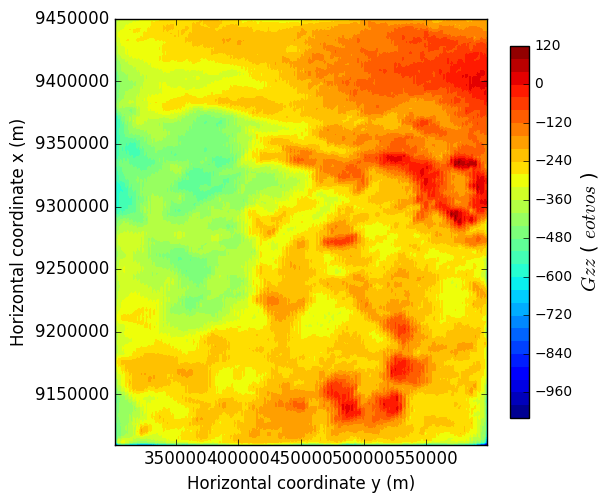

In [55]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6,6))

plt.tricontourf(np.ravel(grid_y),np.ravel(grid_x),gzz,30,cmap='jet')
cb = plt.colorbar(shrink=0.8)
plt.axis('scaled')
cb.set_label('$Gzz$ ( $eotvos$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_c),np.max(yi_c))
plt.ylim(np.min(xi_c),np.max(xi_c))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Horizontal coordinate y (m)', fontsize=12)
plt.ylabel('Horizontal coordinate x (m)', fontsize=12)
#plt.savefig('figures/gzz_carajas_1005x131.jpg', dpi=300)
plt.show()

## Junk Tests

In [44]:
data_right = np.zeros_like(data)
for i in range (shape[1]):
    line = data[i*300:(i+1)*300,:]
    if line[i+1,1] < line[i,1]:
        line_reverse = line[::-1]
        data_right[i*300:(i+1)*300,:] = line_reverse
    else:
        data_right[i*300:(i+1)*300,:] = line

NameError: name 'data' is not defined